In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.special import rel_entr
import seaborn as sns
import matplotlib.pyplot as plt
from pysabr import Hagan2002NormalSABR
from fwdsabr.find_fvol import find_fvol, SabrDist, find_sabr_from_prices, find_sabr
from fwdsabr.option_pricing import compute_option_prices
from datafetchingirta import DataFetcher

Loaded
Loaded


In [11]:
shift = 0.15
f = 0
strikes = np.linspace(-shift+0.02, shift-0.02, 1000)

In [12]:
sabr_p1 = Hagan2002NormalSABR(f = f, shift=shift, t = .5, v_atm_n=0.01, beta=0.5, rho=0.3, volvol=.2)
sabr_p2 = Hagan2002NormalSABR(f = f, shift=shift, t = 1, v_atm_n=0.01, beta=0.5, rho=0.3, volvol=.2)

In [13]:
compute_option_prices(F=f, K=f, vol=sabr_p1.normal_vol(1e-6), T=0.5, call_put='call',)

array([0.00282096])

In [14]:
optimization_result, sabr_p1_p2 = find_fvol(sabr_p1, sabr_p2, strikes)
optimization_result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 289.02315862573863
             x: [ 1.000e-02  1.000e+00  3.934e-01  5.977e-01]
           nit: 185
          nfev: 312
 final_simplex: (array([[ 1.000e-02,  1.000e+00,  3.934e-01,  5.977e-01],
                       [ 1.000e-02,  1.000e+00,  3.935e-01,  5.976e-01],
                       ...,
                       [ 1.000e-02,  1.000e+00,  3.935e-01,  5.976e-01],
                       [ 1.000e-02,  1.000e+00,  3.935e-01,  5.976e-01]]), array([ 2.890e+02,  2.890e+02,  2.890e+02,  2.890e+02,
                        2.890e+02]))

In [15]:
# plt.plot(strikes, sabr_p1_p2.normal_vol(strikes) - sabr_p1.normal_vol(1e-6))
# plt.plot(strikes, (sabr_p1.normal_vol(strikes) - sabr_p1.normal_vol(1e-6)) * 4, label='SABR P1')

(0.010000046714133647, 0.010002988359482708)

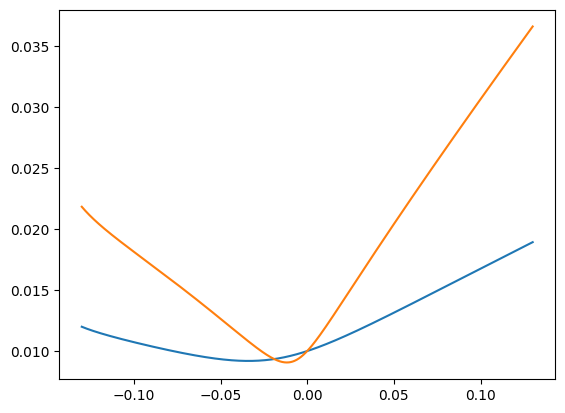

: 

In [ ]:
plt.plot(strikes, sabr_p1.normal_vol(strikes), label='SABR P1')
plt.plot(strikes, sabr_p1_p2.normal_vol(strikes), label='SABR P1+P2')
sabr_p1.normal_vol(1e-6), sabr_p1_p2.normal_vol(1e-6)

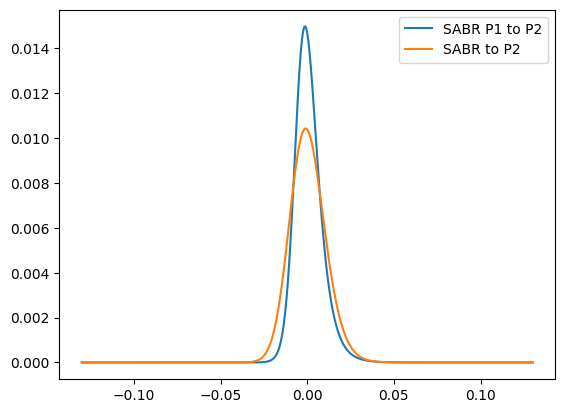

In [8]:
sabr_dist_p1 = SabrDist.from_sabr(sabr_p1)
sabr_dist_p1_p2 = SabrDist.from_sabr(sabr_p1_p2)
sabr_dist_p2 = SabrDist.from_sabr(sabr_p2)

pdf_p1 = sabr_dist_p1.pdf(strikes) / sabr_dist_p1.pdf(strikes).sum()
pdf_p1_p2 = sabr_dist_p1_p2.pdf(strikes) / sabr_dist_p1_p2.pdf(strikes).sum()
pdf_p2 = sabr_dist_p2.pdf(strikes) / sabr_dist_p2.pdf(strikes).sum()

plt.plot(strikes, pdf_p1_p2, label='SABR P1 to P2')
plt.plot(strikes, pdf_p2, label='SABR to P2')
plt.legend()

In [ ]:
sampled_p1 = sabr_dist_p1.rvs(size=5_000) 
sampled_vols_p1_p2 = sabr_p1_p2.normal_vol(sampled_p1)
sampled_p1_p2 = np.random.randn(5_000, sampled_vols_p1_p2.shape[0]) * sampled_vols_p1_p2 * np.sqrt(.5) 
total = (sampled_p1 + sampled_p1_p2).flatten()

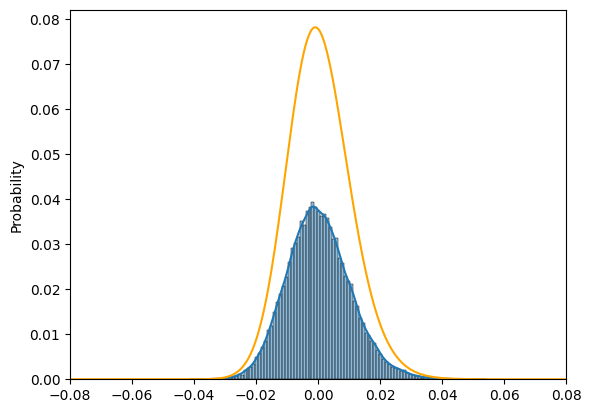

In [10]:
sns.histplot(total[:50_000], kde=True, stat='probability', bins=100, label='Total')
plt.xlim(strikes[0] +.05, strikes[-1] -.05)
plt.plot(strikes, pdf_p2 * 7.5, label='SABR P2', color='orange')

In [113]:
total<strikes.reshape(-1,1)

KeyboardInterrupt: 

In [79]:
# pdf_p2[strikes < -0.04].sum(), (total<-0.04).mean()

In [80]:
vols_p1_p2 = sabr_p1_p2.normal_vol(strikes)
pdf = ss.norm.pdf(strikes.reshape(-1, 1), loc = strikes.reshape(1, -1), scale = vols_p1_p2.reshape(1, -1) * np.sqrt(.5))
pdf_df = pd.DataFrame(pdf, columns=pd.Index(strikes, name='Rate At Start'), index=pd.Index(strikes, name='Rate At End'))
pdf_df = pdf_df / pdf_df.sum()
pdf_total = (pdf_df * pdf_p1).sum(axis=1)


In [81]:
kl = np.sum(rel_entr(pdf_total, pdf_p2)) * 100
kl

np.float64(0.14095818526004833)

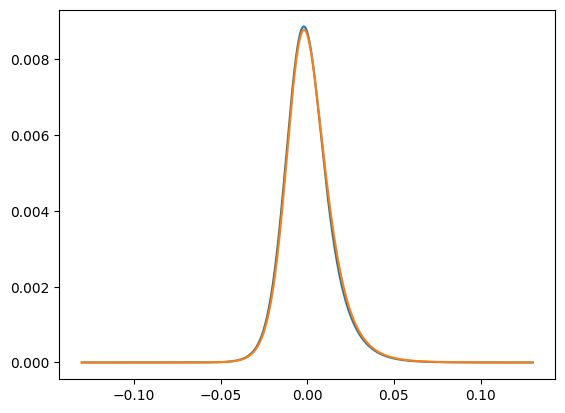

In [82]:
plt.plot(strikes, pdf_total)
plt.plot(strikes, pdf_p2, label='SABR P1')